# 1. 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings(action='ignore')

# 2. 데이터 가져오기

In [2]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('./train.csv').drop(columns=['UID'])
test_df = pd.read_csv('./test.csv').drop(columns=['UID'])

In [3]:
train_df

,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,대출 목적,대출 상환 기간,현재 대출 잔액,현재 미상환 신용액,월 상환 부채액,신용 점수,채무 불이행 여부
0,자가,1941337.5,10년 이상,0.0,9,13.4,400597.5,0,24,1,부채 통합,단기 상환,390903.0,225457.5,8806.5,767,0
1,월세,1979505.0,10년 이상,0.0,5,15.1,360679.5,0,11,0,부채 통합,단기 상환,1002184.5,64749.0,24961.5,767,0
2,월세,1356381.0,4년,0.0,12,18.8,491770.5,1,74,3,부채 통합,단기 상환,227775.0,487644.0,12069.0,800,1
3,월세,1049017.5,6년,0.0,15,14.8,411546.0,1,22,1,부채 통합,단기 상환,251383.5,413211.0,31749.0,796,1
4,월세,4320217.5,2년,0.0,11,26.1,895288.5,0,32,0,부채 통합,장기 상환,1163176.5,78991.5,5862.0,751,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,주택 담보 대출 (거주 중),1339473.0,10년 이상,0.0,9,18.7,319027.5,0,68,0,부채 통합,단기 상환,126216.0,177028.5,6237.0,755,0
9996,주택 담보 대출 (거주 중),2297230.5,2년,0.0,11,28.3,399799.5,0,7,0,주택 개보수,장기 상환,371907.0,347449.5,53301.0,707,0
9997,주택 담보 대출 (거주 중),1221523.5,10년 이상,0.0,9,30.1,823305.0,0,14,0,부채 통합,장기 상환,869736.0,176905.5,11436.0,733,0
9998,자가,3343584.0,10년 이상,0.0,10,20.3,724314.0,0,25,0,부채 통합,단기 상환,443008.5,139294.5,25567.5,696,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  object 
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  object 
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  int64  
 5   신용 거래 연수           10000 non-null  float64
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  object 
 11  대출 상환 기간           10000 non-null  object 
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  int64  
 16  채무 불이행 여부          1000

# 3. Pre-processing (전처리)

In [5]:
categorical_col = [
    '주거 형태',
    '현재 직장 근속 연수',
    '대출 목적',
    '대출 상환 기간'
]

# OneHotEncoder 초기화
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# 훈련 데이터에 대해 인코더 학습
encoder.fit(train_df[categorical_col])

# 훈련 데이터와 테스트 데이터 변환
train_encoded = encoder.transform(train_df[categorical_col])
test_encoded = encoder.transform(test_df[categorical_col])

# One-hot encoding 결과를 데이터프레임으로 변환
train_encoded_train_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_col))
test_encoded_train_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_col))

# 인코딩된 결과를 원래 데이터에 적용
train_df = pd.concat([train_df.drop(columns=categorical_col).reset_index(drop=True), train_encoded_train_df], axis=1)
test_df = pd.concat([test_df.drop(columns=categorical_col).reset_index(drop=True), test_encoded_train_df], axis=1)

In [6]:
train_df

,연간 소득,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,현재 대출 잔액,현재 미상환 신용액,...,대출 목적_소규모 사업 자금,대출 목적_여행 자금,대출 목적_의료비,대출 목적_이사 비용,대출 목적_자동차 구매,대출 목적_주택 개보수,대출 목적_주택 구매,대출 목적_휴가 비용,대출 상환 기간_단기 상환,대출 상환 기간_장기 상환
0,1941337.5,0.0,9,13.4,400597.5,0,24,1,390903.0,225457.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1979505.0,0.0,5,15.1,360679.5,0,11,0,1002184.5,64749.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1356381.0,0.0,12,18.8,491770.5,1,74,3,227775.0,487644.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1049017.5,0.0,15,14.8,411546.0,1,22,1,251383.5,413211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4320217.5,0.0,11,26.1,895288.5,0,32,0,1163176.5,78991.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1339473.0,0.0,9,18.7,319027.5,0,68,0,126216.0,177028.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9996,2297230.5,0.0,11,28.3,399799.5,0,7,0,371907.0,347449.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9997,1221523.5,0.0,9,30.1,823305.0,0,14,0,869736.0,176905.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9998,3343584.0,0.0,10,20.3,724314.0,0,25,0,443008.5,139294.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# EDA

In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
연간 소득,10000.0,2.163959e+06,1.434430e+06,267621.0,1311437.250,1743222.75,2447664.000,17229747.0
체납 세금 압류 횟수,10000.0,1.993000e-01,7.143042e-01,0.0,0.000,0.00,0.000,7.0
개설된 신용계좌 수,10000.0,1.224890e+01,4.620572e+00,2.0,9.000,12.00,15.000,35.0
신용 거래 연수,10000.0,1.987936e+01,7.206693e+00,6.0,14.600,17.95,24.100,51.7
최대 신용한도,10000.0,1.175265e+06,1.604199e+06,0.0,448247.625,767091.00,1147282.875,23232333.0
신용 문제 발생 횟수,10000.0,6.262000e-01,1.234190e+00,0.0,0.000,0.00,1.000,7.0
마지막 연체 이후 경과 개월 수,10000.0,3.088920e+01,2.001156e+01,0.0,14.000,28.00,41.000,88.0
개인 파산 횟수,10000.0,3.732000e-01,8.437968e-01,0.0,0.000,0.00,0.000,3.0
현재 대출 잔액,10000.0,5.061200e+05,2.831462e+05,29176.5,300190.125,474341.25,591907.875,1373613.0
현재 미상환 신용액,10000.0,3.649126e+05,3.537942e+05,0.0,147185.625,254793.00,474918.000,3946300.5


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   연간 소득                   10000 non-null  float64
 1   체납 세금 압류 횟수             10000 non-null  float64
 2   개설된 신용계좌 수              10000 non-null  int64  
 3   신용 거래 연수                10000 non-null  float64
 4   최대 신용한도                 10000 non-null  float64
 5   신용 문제 발생 횟수             10000 non-null  int64  
 6   마지막 연체 이후 경과 개월 수       10000 non-null  int64  
 7   개인 파산 횟수                10000 non-null  int64  
 8   현재 대출 잔액                10000 non-null  float64
 9   현재 미상환 신용액              10000 non-null  float64
 10  월 상환 부채액                10000 non-null  float64
 11  신용 점수                   10000 non-null  int64  
 12  채무 불이행 여부               10000 non-null  int64  
 13  주거 형태_월세                10000 non-null  float64
 14  주거 형태_자가                10000 non-null 

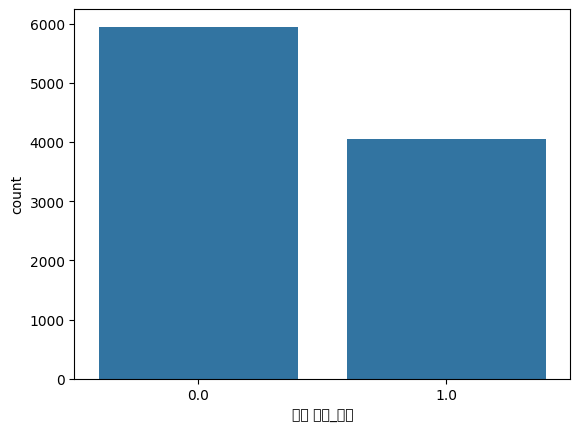

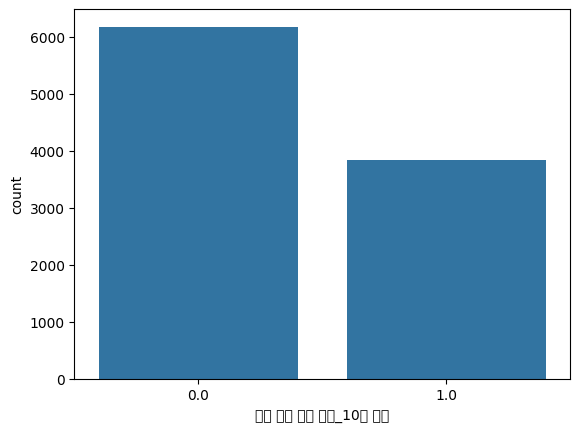

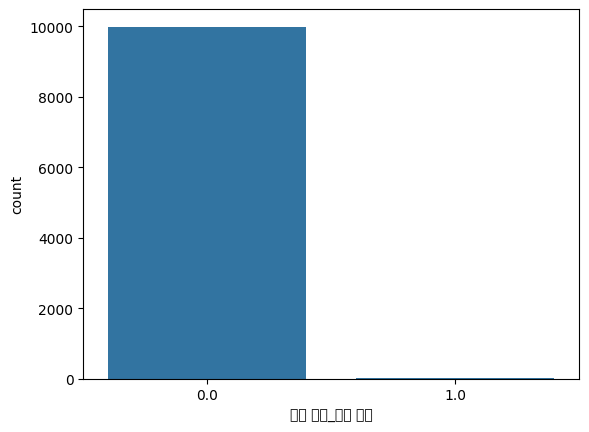

In [9]:
train_df = train_df

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='주거 형태_월세', data=train_df)
plt.show()
sns.countplot(x='현재 직장 근속 연수_10년 이상', data=train_df)
plt.show()
sns.countplot(x='대출 목적_결혼 자금', data=train_df)
plt.show()

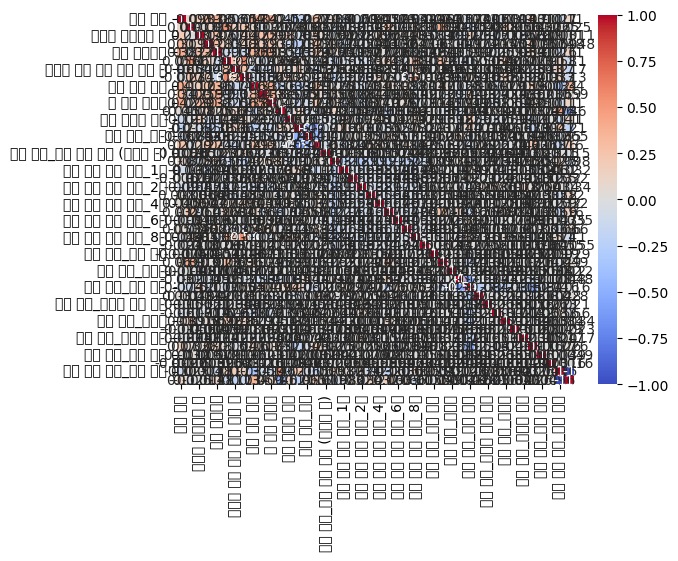

In [10]:
corr = train_df.corr()  # 상관 행렬 계산
sns.heatmap(corr, annot=True, cmap='coolwarm')  # 상관 행렬 시각화
plt.show()

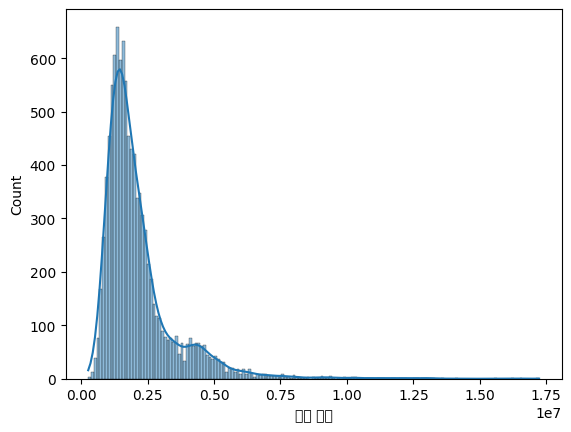

In [11]:
sns.histplot(train_df['연간 소득'], kde=True)
plt.show()

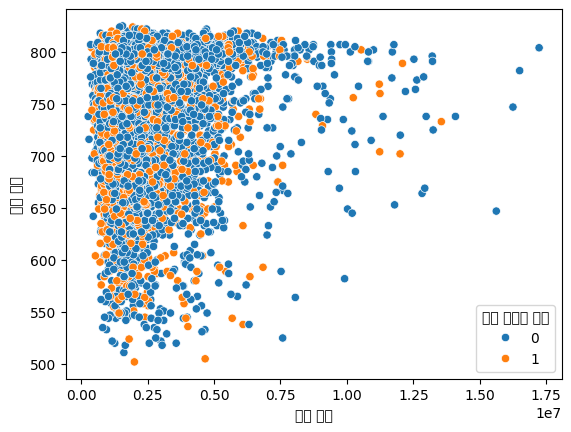

In [12]:
sns.scatterplot(x='연간 소득', y='신용 점수', hue='채무 불이행 여부', data=train_df)
plt.show()

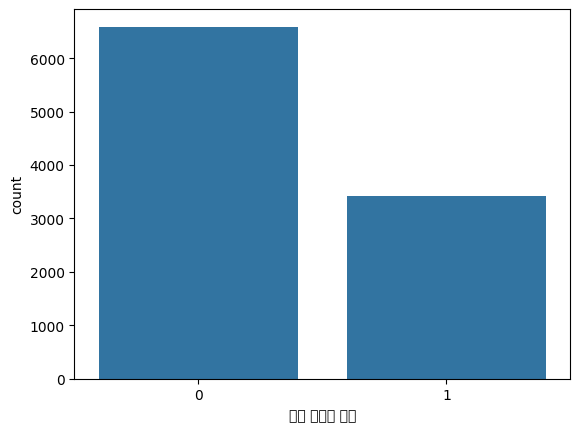

In [13]:
sns.countplot(x='채무 불이행 여부', data=train_df)
plt.show()

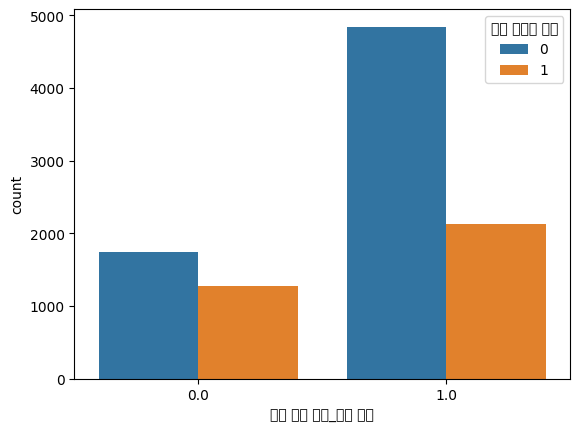

In [14]:
sns.countplot(x='대출 상환 기간_단기 상환', hue='채무 불이행 여부', data=train_df)
plt.show()

In [39]:
# 1. 소득 대비 채무 비율 (Debt-to-Income Ratio)
train_df['Debt_to_Income_Ratio'] = (train_df['현재 대출 잔액'] + train_df['현재 미상환 신용액'] + train_df['월 상환 부채액']) / train_df['연간 소득']
# 3. 최대 신용 한도와 개설된 신용계좌 수의 비율
train_df['Credit_Limit_per_Account'] = train_df['최대 신용한도'] / train_df['개설된 신용계좌 수']
# 4. 소득 대비 신용 점수 비율 (Income-to-Credit Score Ratio)
train_df['Income_to_Credit_Score_Ratio'] = train_df['연간 소득'] / train_df['신용 점수']
# 5. 대출 목적에 따른 부채 분류 (부채 통합 여부)
train_df['Debt_Consolidation_Indicator'] = train_df['대출 목적_부채 통합']
# 6. 대출 상환 기간에 따른 신용 문제 발생 가능성
train_df['Long_Term_Loan_Indicator'] = train_df['대출 상환 기간_장기 상환']
# 7. 직장 근속 연수와 대출 상환 기간의 관계 (직장 근속 10년 이상 × 대출 상환 기간)
train_df['Stable_Employment_Loan_Relationship'] = train_df['현재 직장 근속 연수_10년 이상'] * train_df['대출 상환 기간_단기 상환']
# 8. 신용 한도와 신용 문제 발생 횟수의 관계
train_df['Credit_Limit_to_Credit_Issues'] = train_df['최대 신용한도'] / (train_df['신용 문제 발생 횟수'] + 1)

# 1. 소득 대비 채무 비율 (Debt-to-Income Ratio)
test_df['Debt_to_Income_Ratio'] = (test_df['현재 대출 잔액'] + test_df['현재 미상환 신용액'] + test_df['월 상환 부채액']) / test_df['연간 소득']
# 3. 최대 신용 한도와 개설된 신용계좌 수의 비율
test_df['Credit_Limit_per_Account'] = test_df['최대 신용한도'] / test_df['개설된 신용계좌 수']
# 4. 소득 대비 신용 점수 비율 (Income-to-Credit Score Ratio)
test_df['Income_to_Credit_Score_Ratio'] = test_df['연간 소득'] / test_df['신용 점수']
# 5. 대출 목적에 따른 부채 분류 (부채 통합 여부)
test_df['Debt_Consolidation_Indicator'] = test_df['대출 목적_부채 통합']
# 6. 대출 상환 기간에 따른 신용 문제 발생 가능성
test_df['Long_Term_Loan_Indicator'] = test_df['대출 상환 기간_장기 상환']
# 7. 직장 근속 연수와 대출 상환 기간의 관계 (직장 근속 10년 이상 × 대출 상환 기간)
test_df['Stable_Employment_Loan_Relationship'] = test_df['현재 직장 근속 연수_10년 이상'] * test_df['대출 상환 기간_단기 상환']
# 8. 신용 한도와 신용 문제 발생 횟수의 관계
test_df['Credit_Limit_to_Credit_Issues'] = test_df['최대 신용한도'] / (test_df['신용 문제 발생 횟수'] + 1)

In [43]:
# Inf 값을 NaN으로 변환
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 0 또는 다른 값으로 대체하거나 제거
train_df.fillna(0, inplace=True)  # NaN을 0으로 대체
test_df.fillna(0, inplace=True)  # NaN을 0으로 대체

In [73]:
train_select_columns = ['채무 불이행 여부', '개설된 신용계좌 수', '개인 파산 횟수', 'Debt_to_Income_Ratio', 'Credit_Limit_per_Account', 'Income_to_Credit_Score_Ratio', 'Debt_Consolidation_Indicator', 'Long_Term_Loan_Indicator', 'Stable_Employment_Loan_Relationship', 'Credit_Limit_to_Credit_Issues']
test_select_columns = ['개설된 신용계좌 수', '개인 파산 횟수', 'Debt_to_Income_Ratio', 'Credit_Limit_per_Account', 'Income_to_Credit_Score_Ratio', 'Debt_Consolidation_Indicator', 'Long_Term_Loan_Indicator', 'Stable_Employment_Loan_Relationship', 'Credit_Limit_to_Credit_Issues']

train_df[train_select_columns].corr()

,채무 불이행 여부,개설된 신용계좌 수,개인 파산 횟수,Debt_to_Income_Ratio,Credit_Limit_per_Account,Income_to_Credit_Score_Ratio,Debt_Consolidation_Indicator,Long_Term_Loan_Indicator,Stable_Employment_Loan_Relationship,Credit_Limit_to_Credit_Issues
채무 불이행 여부,1.000000,0.169900,0.115900,0.143741,-0.088931,-0.109902,0.198585,0.113358,-0.105042,-0.056297
개설된 신용계좌 수,0.169900,1.000000,0.138699,0.087814,-0.031392,0.188359,0.119333,-0.001127,-0.050143,0.230612
개인 파산 횟수,0.115900,0.138699,1.000000,-0.106237,-0.140873,-0.028837,0.053855,-0.128475,-0.170010,-0.194981
Debt_to_Income_Ratio,0.143741,0.087814,-0.106237,1.000000,0.069684,-0.345468,0.193845,0.131154,-0.069551,0.092433
Credit_Limit_per_Account,-0.088931,-0.031392,-0.140873,0.069684,1.000000,0.305116,-0.034773,0.108073,0.015303,0.854717
Income_to_Credit_Score_Ratio,-0.109902,0.188359,-0.028837,-0.345468,0.305116,1.000000,-0.084999,0.170288,-0.021642,0.336861
Debt_Consolidation_Indicator,0.198585,0.119333,0.053855,0.193845,-0.034773,-0.084999,1.000000,-0.016384,-0.012036,-0.003757
Long_Term_Loan_Indicator,0.113358,-0.001127,-0.128475,0.131154,0.108073,0.170288,-0.016384,1.000000,-0.419758,0.134192
Stable_Employment_Loan_Relationship,-0.105042,-0.050143,-0.170010,-0.069551,0.015303,-0.021642,-0.012036,-0.419758,1.000000,0.010461
Credit_Limit_to_Credit_Issues,-0.056297,0.230612,-0.194981,0.092433,0.854717,0.336861,-0.003757,0.134192,0.010461,1.000000


# 4. Train / Validation Split (학습 데이터 분할)

In [74]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df[train_select_columns].drop(columns=['채무 불이행 여부']), 
    train_df['채무 불이행 여부'], 
    test_size=0.2, 
    random_state=42
)

# 5. Model Training (모델 학습)

In [75]:
# XGBoost 모델 학습
model = XGBClassifier(
    n_estimators=100,  # 트리 개수
    max_depth=6,       # 최대 깊이
    learning_rate=0.3, # 학습률
    random_state=42,
    use_label_encoder=False,  # 경고 방지
    eval_metric="auc",        # 평가 지표 설정
    early_stopping_rounds=10,  # 5번의 학습 동안 성능 개선 없을 시 조기 종료
)

# 학습 및 Validation 성능 모니터링
eval_set = [(X_train, y_train), (X_val, y_val)]

model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=True,  # 학습 로그 출력
)

[0]	validation_0-auc:0.73469	validation_1-auc:0.68906
[1]	validation_0-auc:0.74969	validation_1-auc:0.69883
[2]	validation_0-auc:0.75949	validation_1-auc:0.70310
[3]	validation_0-auc:0.76775	validation_1-auc:0.70673
[4]	validation_0-auc:0.77414	validation_1-auc:0.70884
[5]	validation_0-auc:0.77947	validation_1-auc:0.70985
[6]	validation_0-auc:0.78904	validation_1-auc:0.71237
[7]	validation_0-auc:0.79483	validation_1-auc:0.71134
[8]	validation_0-auc:0.79940	validation_1-auc:0.71180
[9]	validation_0-auc:0.80590	validation_1-auc:0.70845
[10]	validation_0-auc:0.80847	validation_1-auc:0.70876
[11]	validation_0-auc:0.81122	validation_1-auc:0.71048
[12]	validation_0-auc:0.81653	validation_1-auc:0.70916
[13]	validation_0-auc:0.81927	validation_1-auc:0.70977
[14]	validation_0-auc:0.82243	validation_1-auc:0.70809
[15]	validation_0-auc:0.82494	validation_1-auc:0.70808
[16]	validation_0-auc:0.83268	validation_1-auc:0.70528


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# 6. Prediction

In [76]:
# 채무 불이행 '확률'을 예측합니다.
preds = model.predict_proba(test_df[test_select_columns])[:,1]

In [78]:
submit = pd.read_csv('./sample_submission.csv')

# 결과 저장
submit['채무 불이행 확률'] = preds
submit.to_csv('./submission_10.csv', encoding='UTF-8-sig', index=False)

submit

,UID,채무 불이행 확률
0,TEST_0000,0.292538
1,TEST_0001,0.396801
2,TEST_0002,0.397981
3,TEST_0003,0.259255
4,TEST_0004,0.280781
...,...,...
2057,TEST_2057,0.084028
2058,TEST_2058,0.228924
2059,TEST_2059,0.320047
2060,TEST_2060,0.302032
